In [33]:
# This code should be run in console room computer to display the feedback morphings
from __future__ import print_function, division
import sys
sys.path.append('/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/feedback/')

#os.chdir("/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtSynth_repo/kp_scratch/expcode")
from psychopy import visual, event, core, logging, gui, data, monitors
from psychopy.hardware.emulator import launchScan, SyncGenerator
from PIL import Image
import string
import fmrisim as sim
import numpy as np
import pandas as pd
import sys
import os
import pylink
from tqdm import tqdm
import time
import re
alpha = string.ascii_uppercase

if 'watts' in os.getcwd():
    main_dir = "/home/watts/Desktop/ntblab/kailong/rtcloud_kp/"
else:
    main_dir="/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/"

# startup parameters
sub = 'pilot_sub003' #sys.argv[1] #'pilot_sub001' # # this is the name of the subject
sess = 2 #int(sys.argv[2]) #2 #  which session is this in? by design this can be 2 3 4 
run = 1 #sys.argv[3] #1 # # which run is this in
scanmode = 'Test'  # 'Scan' or 'Test' or None
screenmode = False  # fullscr True or False


gui = True if screenmode == False else False
monitor_name = "testMonitor" # scanner testMonitor
scnWidth, scnHeight = monitors.Monitor(monitor_name).getSizePix()
frameTolerance = 0.001  # how close to onset before 'same' frame
TRduration=2.0

# mywin = visual.Window(
    # size=[1280, 800], fullscr=screenmode, screen=0,
    # winType='pyglet', allowGUI=False, allowStencil=False,
    # monitor=monitor_name, color=[0,0,0], colorSpace='rgb', #color=[0,0,0]
    # blendMode='avg', useFBO=True,
    # units='height')

mywin = visual.Window(
    size=[scnWidth - 100, scnHeight - 100], fullscr=screenmode, screen=1,
    winType='pyglet', allowGUI=False, allowStencil=False,
    monitor=monitor_name, color=[0,0,0], colorSpace='rgb', #color=[0,0,0]
    blendMode='avg', useFBO=True,
    units='height')

# similation specific
step=3 #in simulation, how quickly the morph changes ramp up. Note this is only for simulation, has nothing to do with real experiment

# trial_list designing parameters
TR=2 # the length of a TR is 2s
parameterRange=np.arange(1,20) #for saving time for now. np.arange(1,20) #define the range for possible parameters for preloading images. Preloading images is to make the morphing smooth during feedback
tune=4 # this parameter controls how much to morph (how strong the morphing is) (used in preloading function), tune can range from (1,6.15] when paremeterrange is np.arange(1,20)
TrialNumber=10 #how many trials are required #test trial ,each trial is 14s, 10 trials are 140s.

## - design the trial list: the sequence of the different types of components: 
## - e.g: ITI + waiting for fMRI signal + feedback (receive model output from feedbackReceiver.py)
trial_list = pd.DataFrame(columns=['Trial','time','TR','state','newWobble'])
curTime=0
curTR=0
state=''
trial_list.append({'Trial':None,
                    'time':None,
                    'TR':None,
                    'state':None,
                    'newWobble':None},
                    ignore_index=True)

for currTrial in range(1,1+TrialNumber):

    # ITI
    for i in range(6): # should be 6TR=12s
        trial_list=trial_list.append({'Trial':currTrial,
                                    'time':curTime,
                                    'TR':curTR,
                                    'state':'ITI',
                                    'newWobble':0},
                                    ignore_index=True)
        curTime=curTime+TR
        curTR=curTR+1

    # waiting for metric calculation
    for i in range(3): # should be 3TR=6s
        trial_list=trial_list.append({'Trial':currTrial,
                                    'time':curTime,
                                    'TR':curTR,
                                    'state':'waiting',
                                    'newWobble':0},
                                    ignore_index=True)
        curTime=curTime+TR
        curTR=curTR+1
    
    # feedback trial: try minimize the whobbling
    for i in range(5): #5TR=10s
        trial_list=trial_list.append({'Trial':currTrial,
                                    'time':curTime,
                                    'TR':curTR,
                                    'state':'feedback',
                                    'newWobble':1},
                                    ignore_index=True)
        curTime=curTime+TR
        curTR=curTR+1

# ITI
for i in range(6): # should be 6TR=12s
    trial_list=trial_list.append({'Trial':currTrial,
                                'time':curTime,
                                'TR':curTR,
                                'state':'ITI',
                                'newWobble':0},
                                ignore_index=True)
    curTime=curTime+TR
    curTR=curTR+1

# parameters = np.arange(1,step*(sum((trial_list['newWobble']==1)*1)),step) #[1,2,3,4,5,6,7,8]

print('total trial number=',TrialNumber)
# print('neighboring morph difference=',tune)
print('preloaded parameter range=',parameterRange)
# print('used parameters=',parameters)



def sample(L,num=10):
    # This functional uniformly sample the list to be num points
    # e.g, if L is 0-99, num is 10, newList would be [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
    # e.g, if L is 0-95, num is 10, newList would be [8, 18, 27, 37, 47, 56, 66, 75, 85, 95]
    # e.g, if L is 0-5, num is 10, newList would be [0, 0, 0, 1, 2, 2, 3, 3, 4, 5]
    sampleStep=len(L)/num 
    newList=[]
    for i in range(1,num):
        newList.append(L[int(i*sampleStep-1)])
    newList.append(L[-1])
    return newList

# imageFolder="/Users/kailong/Desktop/rtEnv/rtSynth_rt/expScripts/feedback/"
imageFolder="/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/expScripts/feedback/"
# preload image list for parameter from 1 to 10.
def preloadimages(parameterRange=np.arange(1,20),tune=1):
    tune=tune-1
    start = time.time()
    imageLists={}
    numberOfUpdates=16 # corresponds to 66 updates    
    last_image=''
    for currParameter in tqdm(parameterRange): #49
        images=[]
        print('maximum morph=',round((tune*currParameter*numberOfUpdates+2)/numberOfUpdates+1))
        for axis in ['bedTable', 'benchBed']:
            tmp_images=[]
            for currImg in range(1,int(round(tune*currParameter*numberOfUpdates+2)),int((currParameter*numberOfUpdates+2)/numberOfUpdates)):
                currMorph=100-round(currImg/numberOfUpdates+1) if axis=='benchBed' else round(currImg/numberOfUpdates+1)
                if currMorph<1 or currMorph>99:
                    raise Exception('morphing outside limit')
                curr_image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5)
                if curr_image!=last_image:
                    currImage=visual.ImageStim(win=mywin,
                                                name='image',
                                                image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5), mask=None,
                                                ori=0, pos=(0, 0), size=(0.5, 0.5),
                                                color=[1,1,1], colorSpace='rgb', opacity=1,
                                                flipHoriz=False, flipVert=False,
                                                texRes=128, interpolate=True, depth=-4.0)
                tmp_images.append(currImage)
                last_image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5)
            images=images+sample(tmp_images)
            tmp_images=[]
            for currImg in reversed(range(1,int(round(tune*currParameter*numberOfUpdates+1)),int((currParameter*numberOfUpdates+2)/numberOfUpdates))):
                currMorph=100-round(currImg/numberOfUpdates+1) if axis=='benchBed' else round(currImg/numberOfUpdates+1)
                curr_image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5)
                if curr_image!=last_image:
                    currImage=visual.ImageStim(win=mywin,
                                                name='image',
                                                image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5), mask=None,
                                                ori=0, pos=(0, 0), size=(0.5, 0.5),
                                                color=[1,1,1], colorSpace='rgb', opacity=1,
                                                flipHoriz=False, flipVert=False,
                                                texRes=128, interpolate=True, depth=-4.0)
                tmp_images.append(currImage)
                last_image=imageFolder+'carchair_exp_feedback/{}_{}_{}.png'.format(axis,currMorph,5)
            images=images+sample(tmp_images)
        imageLists.update( {currParameter : images} )
    end = time.time()
    print("preload image duration=", end - start)
    return imageLists

imageLists=preloadimages(parameterRange=parameterRange,tune=tune)

  0%|          | 0/19 [00:00<?, ?it/s]

total trial number= 10
preloaded parameter range= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
maximum morph= 4.0


  5%|▌         | 1/19 [00:00<00:09,  2.00it/s]

maximum morph= 7.0


 11%|█         | 2/19 [00:01<00:11,  1.48it/s]

maximum morph= 10.0


 16%|█▌        | 3/19 [00:03<00:15,  1.05it/s]

maximum morph= 13.0


 21%|██        | 4/19 [00:05<00:18,  1.25s/it]

maximum morph= 16.0


 26%|██▋       | 5/19 [00:07<00:22,  1.60s/it]

maximum morph= 19.0


 32%|███▏      | 6/19 [00:10<00:26,  2.04s/it]

maximum morph= 22.0


 37%|███▋      | 7/19 [00:13<00:28,  2.39s/it]

maximum morph= 25.0


 42%|████▏     | 8/19 [00:17<00:29,  2.71s/it]

maximum morph= 28.0


 47%|████▋     | 9/19 [00:21<00:30,  3.07s/it]

maximum morph= 31.0


 53%|█████▎    | 10/19 [00:25<00:32,  3.59s/it]

maximum morph= 34.0


 58%|█████▊    | 11/19 [00:30<00:31,  4.00s/it]

maximum morph= 37.0


 63%|██████▎   | 12/19 [00:36<00:31,  4.53s/it]

maximum morph= 40.0


 68%|██████▊   | 13/19 [00:43<00:30,  5.06s/it]

maximum morph= 43.0


 74%|███████▎  | 14/19 [00:49<00:27,  5.55s/it]

maximum morph= 46.0


 79%|███████▉  | 15/19 [00:57<00:24,  6.17s/it]

maximum morph= 49.0


 84%|████████▍ | 16/19 [01:05<00:19,  6.65s/it]

maximum morph= 52.0


 89%|████████▉ | 17/19 [01:12<00:14,  7.00s/it]

maximum morph= 55.0


 95%|█████████▍| 18/19 [01:21<00:07,  7.39s/it]

maximum morph= 58.0


100%|██████████| 19/19 [01:29<00:00,  4.68s/it]

preload image duration= 89.01172971725464


In [8]:
trial_list['TR']

0        0
1        1
2        2
3        3
4        4
      ... 
141    141
142    142
143    143
144    144
145    145
Name: TR, Length: 146, dtype: object

In [38]:
# Open data file for eye tracking
# datadir = "./data/feedback/"
datadir = main_dir + f"subjects/{sub}/ses{sess}_feedback/"

maxTR=int(trial_list['TR'].iloc[-1])+6
# Settings for MRI sequence
MR_settings = {'TR': TRduration, 'volumes': maxTR, 'sync': 5, 'skip': 0, 'sound': True} #{'TR': 2.000, 'volumes': maxTR, 'sync': 5, 'skip': 0, 'sound': True}

# check if there is a data directory and if there isn't, make one.
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('./data/feedback/'):
    os.mkdir('./data/feedback/')

# check if data for this subject and run already exist, and raise an error if they do (prevent overwriting)
newfile = datadir+"{}_{}.csv".format(str(sub), str(run))
if os.path.exists(newfile):
    raise Exception(f'{newfile} exists')
# create empty dataframe to accumulate data
data = pd.DataFrame(columns=['Sub', 'Run', 'TR', 'time'])

# Create the fixation dot, and initialize as white fill.
fix = visual.Circle(mywin, units='deg', radius=0.05, pos=(0, 0), fillColor='white',
                    lineColor='black', lineWidth=0.5, opacity=0.5, edges=128)

# start global clock and fMRI pulses (start simulated or wait for real)
print('Starting sub {} in run #{}'.format(sub, run))

vol = launchScan(mywin, MR_settings, simResponses=None, mode=scanmode,
                 esc_key='escape', instr='select Scan or Test, press enter',
                 wait_msg='waiting for scanner...', wait_timeout=300, log=True)

image = visual.ImageStim(
    win=mywin,
    name='image',
    image=imageFolder+'./carchair_exp_feedback/bedChair_1_5.png', mask=None,
    ori=0, pos=(0, 0), size=(0.5, 0.5),
    color=[1,1,1], colorSpace='rgb', opacity=1,
    flipHoriz=False, flipVert=False,
    texRes=128, interpolate=True, depth=-4.0)

backgroundImage = visual.ImageStim(
    win=mywin,
    name='image',
    image=imageFolder+'./carchair_exp_feedback/greyBackground.png', mask=None,
    ori=0, pos=(0, 0), size=(0.5, 0.5),
    color=[1,1,1], colorSpace='rgb', opacity=1,
    flipHoriz=False, flipVert=False,
    texRes=128, interpolate=True, depth=-4.0)

# trialClock is reset in each trial to change image every TR (2s), time for each image is 2/numOfImages
trialClock = core.Clock()

# trialClock.add(10)  # initialize as a big enough number to avoid text being shown at the first time.
TR=list(trial_list['TR'])
states=list(trial_list['state'])
newWobble=list(trial_list['newWobble'])

# parameters=np.round(np.random.uniform(0,10,sum((trial_list['newWobble']==1)*1)))
# parameters = np.arange(1,1+sum((trial_list['newWobble']==1)*1)) #[1,2,3,4,5,6,7,8]
parameters = [19, 17, 13, 8, 3, 1, 3, 8, 13, 17] #np.arange(10,1,-1) #[1,2,3,4,5,6,7,8]
ParameterUpdateDuration=np.diff(np.where(trial_list['newWobble']==1))[0][0]*TRduration
curr_parameter=0
remainImageNumber=[]
feedbackParameterFileName=main_dir+f"subjects/{sub}/ses{sess}_feedbackParameter/run_{run}.csv"

# While the running clock is less than the total time, monitor for 5s, which is what the scanner sends for each TR
_=1
# while not os.path.exists(feedbackParameterFileName):
#     keys = event.getKeys(["5","0"])
#     if '0' in keys: # whenever you want to quite, type 0
#         mywin.close()
#         core.quit()
#     time.sleep(0.01)
#     if _ % 100==0:
#         print(f'waiting {feedbackParameterFileName}')
#     _+=1
# parameters=pd.read_csv(feedbackParameterFileName)
# while np.isnan(parameters['value'].iloc[-1]):
#     keys = event.getKeys(["5","0"])
#     if '0' in keys: # whenever you want to quite, type 0
#         mywin.close()
#         core.quit()
#     time.sleep(0.01)
#     if _ % 100==0:
#         print(f'waiting parameters nan')
#     _+=1
#     parameters=pd.read_csv(feedbackParameterFileName)

# curr_parameter=len(parameters['value'])-1
i=0
while len(TR)>1: #globalClock.getTime() <= (MR_settings['volumes'] * MR_settings['TR']) + 3:
    
    
    trialTime = trialClock.getTime()
    keys = event.getKeys(["5","0"])  # check for triggers
    if '0' in keys: # whenever you want to quite, type 0
        mywin.close()
        core.quit()
    if len(keys):
        TR.pop(0)
        states.pop(0)
        newWobble.pop(0)
        print(states[0])
        if states[0] == 'feedback' and newWobble[0]==1:
            # fetch parameter from preprocessing process on Milgram            
            print('feedbackParameterFileName=',feedbackParameterFileName)
#             parameters=pd.read_csv(feedbackParameterFileName)
            # if curr_parameter>(len(parameters['value'])-1):
                # curr_parameter=curr_parameter-1
#             curr_parameter=(len(parameters['value'])-1)
#             curr_parameter=parameters[i]
            parameter=parameters[i]
#             parameter=parameters['value'].iloc[curr_parameter]
#             print('curr_parameter=',curr_parameter)
            print('parameter=',parameter)

#             curr_parameter=curr_parameter+1
            # start new clock for current updating duration (the duration in which only a single parameter is used, which can be 1 TR or a few TRs, the begining of the updateDuration is indicated by the table['newWobble'])
            trialClock=core.Clock()
            trialTime=trialClock.getTime()
            # update the image list to be shown based on the fetched parameter
            imagePaths=imageLists[parameter] #list(imageLists[parameter])
            # calculated how long each image should last.
            eachTime=ParameterUpdateDuration/len(imagePaths)
            # update the image
            # image.image=imagePaths[0]
            image.setAutoDraw(False)
            imagePaths[0].setAutoDraw(True)
            # currImage*eachTime is used in the calculation of the start time of next image in the list.
            
            # save when the image is presented and which image is presented.
            data = data.append({'Sub': sub, 
                                'Run': run, 
                                'TR': TR[0],
                                'time': trialTime, 
                                'imageTime':imagePaths[0].image,
                                'eachTime':eachTime},
                               ignore_index=True)
            oldMorphParameter=re.findall(r"_\w+_",imagePaths[0].image)[1]
            # print('curr morph=',oldMorphParameter)
            remainImageNumber.append(0)
            currImage=1
            i+=1
            # # discard the first image since it has been used.
            # imagePaths.pop(0)
    if (states[0] == 'feedback') and (trialTime>currImage*eachTime):
            try: # sometimes the trialTime accidentally surpasses the maximum time, in this case just do nothing, pass
                imagePaths[currImage-1].setAutoDraw(False)
                imagePaths[currImage].setAutoDraw(True)
                # print('currImage=',imagePaths[currImage],end='\n\n')
                remainImageNumber.append(currImage)

                # write the data!
                data = data.append({'Sub': sub, 
                                    'Run': run, 
                                    'TR': TR[0], 
                                    'time': trialTime, 
                                    'imageTime':imagePaths[currImage].image,
                                    'eachTime':eachTime},
                                    ignore_index=True)
                currMorphParameter=re.findall(r"_\w+_",imagePaths[currImage].image)[1]
                if currMorphParameter!=oldMorphParameter:
                    pass
                    # print('curr morph=',currMorphParameter)
                oldMorphParameter=currMorphParameter
                currImage=currImage+1        
            except:
                pass
    elif states[0] == 'ITI':
        backgroundImage.setAutoDraw(True)
        fix.draw()
    elif states[0] == 'waiting':
        backgroundImage.setAutoDraw(False)
        image.setAutoDraw(True)
    # refresh the screen
    mywin.flip()


# write data out!
data.to_csv(newfile)
mywin.close()
core.quit()


# ##############################################################################
# ##############################################################################
# ##############################################################################
# ####################### simmulated data forparameters#########################
# ##############################################################################
# ##############################################################################
# ##############################################################################
# parameters = pd.DataFrame(columns=['runId','trId','value','timestamp'])
# main_dir="/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/"
# parameterWriteFolder=main_dir+'./subjects/pilot_sub001/ses1_feedbackParameter/'
# if not os.path.isdir(parameterWriteFolder):
#     os.mkdir(parameterWriteFolder)

# for i in range(20):

#     runId=1
#     trId=int(np.random.uniform(1,20,1))
#     value=int(np.random.uniform(1,20,1))
#     timestamp=int(np.random.uniform(0,10,1))
#     parameterFileName=f"{parameterWriteFolder}run_{runId}.csv"
#     print("Dequeue run: {}, tr: {}, value: {}, timestamp: {}".
#           format(runId,trId,value,timestamp))

#     parameters = parameters.append({'runId':runId,
#                         'trId':trId,
#                         'value':value,
#                         'timestamp':timestamp},
#                         ignore_index=True)
#     print('parameters=',parameters)
#     parameters.to_csv(parameterFileName)

Starting sub pilot_sub003 in run #1
ITI
ITI
ITI
ITI
ITI
waiting
waiting
waiting
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/subjects/pilot_sub003/ses2_feedbackParameter/run_1.csv
parameter= 19
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/subjects/pilot_sub003/ses2_feedbackParameter/run_1.csv
parameter= 17
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/subjects/pilot_sub003/ses2_feedbackParameter/run_1.csv
parameter= 13
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/subjects/pilot_sub003/ses2_feedbackParameter/run_1.csv
parameter= 8
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/subjects/pilot_sub003/ses2_feedbackParameter/run_1.csv
parameter= 3
ITI
ITI
ITI
ITI
ITI
ITI
waiting
waiting
waiting
feedback
feedbackParameterFileName= /Volumes/GoogleDrive/My Driv

IndexError: list index out of range

In [32]:
parameter

0

[19, 19, 19, 19, 18, 15, 10, 4, 1, 4]

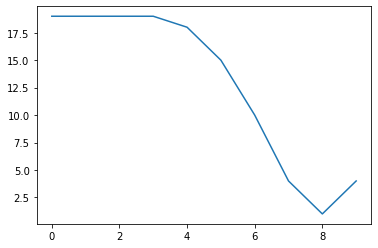

In [44]:
import matplotlib.pyplot as plt
def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    parameters=(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))))
    return [int(round(i)) for i in parameters]

floor=5
ceil=13
# target: floor+(ceil-floor)*1/2=(floor+ceil)/2
mu = (floor+ceil)/2 
#full-width half max: floor+(ceil-floor)*1/4 -> floor+(ceil-floor)*3/4 = (floor-ceil)/2
sig = (floor-ceil)/2/2.3548 

x=np.arange(1,11)
parameters=gaussian(x, mu, sig)

plt.plot(parameters)
parameters

[10, 9, 7, 4, 1, 0, 1, 4, 7, 9]